In [1]:
import os
import numpy as np
import torch 
from utils import ImageTextDataset
import matplotlib.pyplot as plt

   
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [12]:
data_path = "./data"

In [13]:
dataset = ImageTextDataset(data_path)

['a row of motorcycles parked next to each other.', 'a line of motorcycles parked next to parking meters.', 'a line of motorcycles parked on a street', 'a group of motorcyles placed side by side parked on the street', 'a group of motorcycles by a street together.']


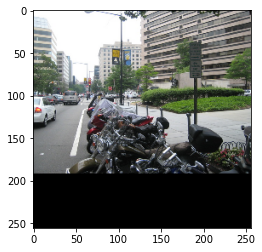

['several people around a table with playing cards.', 'a man shuffles a deck of cards while other people sit around the table.', 'a group of people sitting around a wooden table.', 'five young adults sit around the table playing cards.', 'some people are sitting at a wood table.']


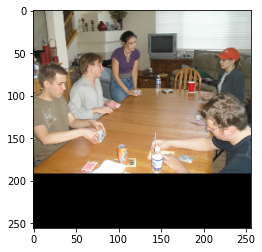

['two bears walking together in the night.', 'two black bears captured together in night vision.', 'two black bears in a wooded area at night.', 'two bears are interrupted on their walk by a surprise picture.', 'a pair of black bears are shown through nightvision.']


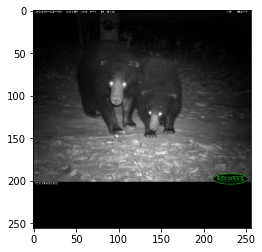

['a gray, white and brown sheep has long hair blowing in the breeze.', 'a sheep standing in the grass with something on its ears.', 'a large hairy sheep standing on a lush green field.', 'a sheep is standing in the grass covered in wool.', 'a very shaggy sheep with tags in its ears.']


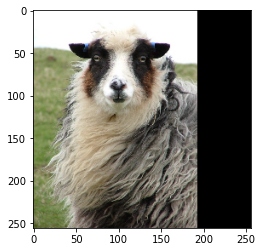

['a dog sits on a bed beside a cell phone.', 'a dog sitting on the bed with a phone and pen.', 'a dog on a bed with a pen and a cell phone', 'a dog sits on a bed next to a cellphone and a pen.', 'a dog sitting on the bed next to cellphone and ink pen.']


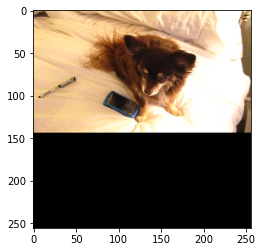

In [14]:
for im, text in dataset:
    print(text)
    plt.figure(figsize=(4, 4))
    plt.imshow(im.detach().cpu().permute(1, 2, 0).numpy())
    plt.show()

In [24]:
import numpy as np
from PIL import Image

from functools import partial, wraps
from tqdm.auto import tqdm
from contextlib import contextmanager

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Pad, Resize, ToPILImage, InterpolationMode, Normalize

from dalle2_laion import ModelLoadConfig, DalleModelManager
from dalle2_laion.scripts import InferenceScript
from dalle2_pytorch.vqgan_vae import NullVQGanVAE, VQGanVAE


from dalle2_pytorch.dalle2_pytorch import maybe, exists, first, resize_image_to
from dalle2_pytorch.dalle2_pytorch import default, cast_tuple, null_context, eval_decorator

import matplotlib.pyplot as plt
from utils import ExampleInference

class SemanticCompressor:
    def __init__(self, config_path, device="cuda:0"):
        self.device = device
        self.model_config = ModelLoadConfig.from_json_path(config_path)

        self.model = ExampleInference(DalleModelManager(self.model_config))
        self.model.model_manager.decoder_info.model.sample_timesteps = (None, 1000)
        self.decoder = self.model.model_manager.decoder_info.model

    def PSNR(self, pred, target):
        pred_unnorm = (pred * 255).to(torch.uint8).detach().cpu().numpy()
        target_unnorm = (target * 255).to(torch.uint8).detach().cpu().numpy()
        return 20 * np.log10(255) - 10 * np.log10(((pred_unnorm - target_unnorm) ** 2).mean())
    
    def p_sample(self, unet, x, t, 
                 image_embed, noise_scheduler, 
                 text_encodings = None, 
                cond_scale = 1., lowres_cond_img = None, 
                 predict_x_start = False, learned_variance = False, 
                clip_denoised = True, lowres_noise_level = None):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.decoder.p_mean_variance(unet, x = x, t = t, 
                                                                  image_embed = image_embed, 
                                                                  text_encodings = text_encodings, 
                                                                  cond_scale = cond_scale, 
                                                                  lowres_cond_img = lowres_cond_img, 
                                                                  clip_denoised = clip_denoised, 
                                                                  predict_x_start = predict_x_start, 
                                                                  noise_scheduler = noise_scheduler, 
                                                                  learned_variance = learned_variance, 
                                                                  lowres_noise_level = lowres_noise_level)
        noise = torch.randn_like(x)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise


    
    def p_sample_loop_ddpm(self,
        unet,
        shape,
        img_init,
        image_embed,
        noise_scheduler,
        predict_x_start = False,
        learned_variance = False,
        clip_denoised = True,
        lowres_cond_img = None,
        text_encodings = None,
        cond_scale = 1,
        is_latent_diffusion = False,
        lowres_noise_level = None,
        target_image=None
    ):
        device = self.decoder.device
        b = shape[0]
        if not is_latent_diffusion:
            lowres_cond_img = maybe(self.decoder.normalize_img)(lowres_cond_img)
        image_embed.requires_grad = True
        lowres_cond_img.requires_grad = True

        psnrs_last = []
        total_losses = []
        optimizer = torch.optim.AdamW([lowres_cond_img, image_embed], lr=1e-4)
        criterion = nn.MSELoss() 
        num_epochs = 2
        for epoch in tqdm(range(num_epochs), leave=False):        
    #         img = torch.randn(lowres_cond_img.shape).cuda()
    #         if epoch == num_epochs - 1:
            img = img_init.to(device)
            img = F.interpolate(img, size=(256, 256), mode='bicubic')

            losses = []
            psnrs = []
            for time in reversed(range(0, noise_scheduler.num_timesteps)):
                is_last_timestep = time == 0
                if time > 20:
                    continue
                times = torch.full((b,), time, device = device, dtype = torch.long)
                img = self.p_sample(
                    unet,
                    img.detach(),
                    times,
                    image_embed = image_embed,
                    text_encodings = text_encodings,
                    cond_scale = cond_scale,
                    lowres_cond_img = lowres_cond_img,
                    lowres_noise_level = lowres_noise_level,
                    predict_x_start = predict_x_start,
                    noise_scheduler = noise_scheduler,
                    learned_variance = learned_variance,
                    clip_denoised = clip_denoised
                )
                optimizer.zero_grad()
                loss = criterion(img, target_image.unsqueeze(0))
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
                psnrs.append(self.PSNR(self.decoder.unnormalize_img(img.detach()).squeeze(0), target_image.cpu()).item())
            if epoch == num_epochs - 1:
                psnrs_last.append(self.PSNR(self.decoder.unnormalize_img(img.detach()).squeeze(0), target_image.cpu()).item())
            total_losses.append(np.mean(losses))
            print(f"EPOCH: {epoch}, mean loss: {total_losses[-1]}, mean psnrs: {np.mean(psnrs)}")

        unnormalize_img = self.decoder.unnormalize_img(img)
        return unnormalize_img, total_losses, psnrs_last


    def p_sample_loop(self, *args, noise_scheduler, timesteps = None, **kwargs):
        num_timesteps = noise_scheduler.num_timesteps
        timesteps = default(timesteps, num_timesteps)
        assert timesteps <= num_timesteps
        is_ddim = timesteps < num_timesteps
        return self.p_sample_loop_ddpm( 
                                  *args, 
                                  noise_scheduler = noise_scheduler, 
                                  **kwargs)


    def sample(self, 
        lowres_cond_img=None,
        image = None,
        image_embed = None,
        text = None,
        text_encodings = None,
        batch_size = 1,
        cond_scale = 1.,
        start_at_unet_number = 1,
        stop_at_unet_number = None,
        distributed = False,
        target_image=None
    ):
        assert self.decoder.unconditional or exists(image_embed), 'image embed must be present on sampling from self.decoder unless if trained unconditionally'

        if not self.decoder.unconditional:
            batch_size = image_embed.shape[0]

        if exists(text) and not exists(text_encodings) and not self.decoder.unconditional:
            assert exists(self.decoder.clip)
            _, text_encodings = model.clip.embed_text(text)

        assert not (self.decoder.condition_on_text_encodings and not exists(text_encodings)), 'text or text encodings must be passed into self.decoder if specified'
        assert not (not self.decoder.condition_on_text_encodings and exists(text_encodings)), 'self.decoder specified not to be conditioned on text, yet it is presented'

        img = None
        if start_at_unet_number > 1:
            # Then we are not generating the first image and one must have been passed in
            assert exists(image), 'image must be passed in if starting at unet number > 1'
            assert image.shape[0] == batch_size, 'image must have batch size of {} if starting at unet number > 1'.format(batch_size)
            prev_unet_output_size = self.decoder.image_sizes[start_at_unet_number - 2]
            img = resize_image_to(image, prev_unet_output_size, nearest = True)
        is_cuda = next(self.decoder.parameters()).is_cuda
        num_unets = self.decoder.num_unets
        cond_scale = cast_tuple(cond_scale, num_unets)

        for unet_number, unet, vae, channel, image_size, predict_x_start, learned_variance, noise_scheduler, lowres_cond, sample_timesteps, unet_cond_scale in tqdm(zip(range(1, num_unets + 1), 
            self.decoder.unets, self.decoder.vaes, self.decoder.sample_channels, self.decoder.image_sizes, 
            self.decoder.predict_x_start, self.decoder.learned_variance, self.decoder.noise_schedulers, 
            self.decoder.lowres_conds, self.decoder.sample_timesteps, cond_scale)):

            if unet_number < start_at_unet_number:
                continue  # It's the easiest way to do it
            context = self.decoder.one_unet_in_gpu(unet = unet) if is_cuda else null_context()

            for param in unet.parameters():
                param.requires_grad = False

            with context:
                # prepare low resolution conditioning for upsamplers
                #lowres_cond_img = lowres_noise_level = None
                lowres_noise_level = None
                shape = (batch_size, channel, image_size, image_size)

                is_latent_diffusion = isinstance(vae, VQGanVAE)
                image_size = vae.get_encoded_fmap_size(image_size)
                shape = (batch_size, vae.encoded_dim, image_size, image_size)

                lowres_cond_img = maybe(vae.encode)(lowres_cond_img)

                # optimisation
                img, losses, psnrs = self.p_sample_loop(
                    unet=unet,
                    shape=shape,
                    img_init=image,
                    image_embed = image_embed,
                    text_encodings = text_encodings,
                    cond_scale = unet_cond_scale,
                    predict_x_start = predict_x_start,
                    learned_variance = learned_variance,
                    clip_denoised = not is_latent_diffusion,
                    lowres_cond_img = lowres_cond_img,
                    lowres_noise_level = lowres_noise_level,
                    is_latent_diffusion = is_latent_diffusion,
                    noise_scheduler = noise_scheduler,
                    timesteps = sample_timesteps,
                    target_image=target_image
                )
                # denoising
                img = self.decoder.p_sample_loop(
                    unet=unet,
                    shape=shape,
                    image_embed = image_embed,
                    text_encodings = text_encodings,
                    cond_scale = unet_cond_scale,
                    predict_x_start = predict_x_start,
                    learned_variance = learned_variance,
                    clip_denoised = not is_latent_diffusion,
                    lowres_cond_img = lowres_cond_img,
                    lowres_noise_level = lowres_noise_level,
                    is_latent_diffusion = is_latent_diffusion,
                    noise_scheduler = noise_scheduler,
                    timesteps = sample_timesteps,
                )
                img = vae.decode(img)
            if exists(stop_at_unet_number) and stop_at_unet_number == unet_number:
                break

        return img, losses, psnrs
    
    
    def run(self, dataset):
        res_list = []
        for i, (target_image, texts) in enumerate(dataset):
            best_psnr = []
            for j, text in enumerate(texts):
                text = [text]
                with torch.no_grad():
                    image_embedding_map = self.model._sample_prior(text)
                    image_embedding = image_embedding_map[0][0].unsqueeze(0).cuda()
                    img_init = F.interpolate(target_image.unsqueeze(0), size=(64, 64), mode="bilinear").cuda() * 2 - 1
                    lowres_cond_img = F.interpolate(img_init, size=(256, 256), mode="bilinear").cuda()


                with torch.no_grad():
                    text_encodings = self.model._encode_text(text).cuda()

                target_image = target_image.cuda()
                self.decoder.cuda()
                target_image.requires_grad = False
                res_img, _, _ = self.sample(
                    lowres_cond_img=lowres_cond_img,
                    image_embed = image_embedding,
                    text_encodings = text_encodings,
                    image=img_init,
                    start_at_unet_number = 2,
                    target_image=target_image
                )

                with torch.no_grad():
                    psnr_measure = self.PSNR(res_img.detach().squeeze(0), target_image).item()

                best_psnr.append(psnr_measure)
            fig, ax = plt.subplots(1, 2, figsize=(12, 6))
            plt.suptitle(f"RGB-PSNR: {psnr_measure:.2f}", fontsize=14)
            ax[0].set_title("Original")
            ax[1].set_title("Result")


            ax[0].imshow(target_image.detach().permute(1, 2, 0).cpu().numpy())
            ax[1].imshow(res_img.detach().squeeze(0).permute(1, 2, 0).cpu().numpy())
            plt.show()
            print(f"Best RGB-PSNR: {max(best_psnr):.2f}")
        return res_list

In [ ]:
config_path = "./configs/dalle2.json"
model = SemanticCompressor(config_path)